In [1]:
%pylab inline
%load_ext autoreload
%autoreload 2

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
import os
import mahotas as mh

In [3]:
import cactas as C

2023-01-29 19:14:08.386753: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


-----------------------------------------
keras-unet init: TF version is >= 2.0.0 - using `tf.keras` instead of `Keras`
-----------------------------------------


In [4]:
# DATAPATH = '/home/d/Dropbox/RESEARCH/CAROTID/DATA/Nathan Arnett Calcification/'
DATAPATH = '/raid/mpsych/CACTAS/DATA/Nathan Arnett Calcification/'

In [5]:
P=64

In [6]:
with open(DATAPATH+'../ESUS_stroke_side.csv', 'r') as f:
    stroke_sides = f.read().replace('ESUS ','').split('\n')

STROKE_SIDES = {}
    
for l in stroke_sides[1:]:
    l_s = l.split(',')
    
    if len(l_s) != 5:
        continue
    
    id_ = l_s[0]
    age = l_s[1]
    sex = l_s[2]
    race = l_s[3]
    side = l_s[4]
    STROKE_SIDES[id_] = side

DICOM 12-checked
Stroke side L
DICOM 13
Stroke side L
DICOM 16
Stroke side L
DICOM 17
Stroke side R
DICOM 17 no asymp plaque
DICOM 18
Stroke side L
DICOM 21
Stroke side R
DICOM 22
Stroke side L
DICOM 23
Stroke side L
DICOM 24
Stroke side R
DICOM 25
Stroke side L
DICOM 26
Stroke side R


/home/daniel.haehn/Projects/CACTAS/_EXPERIMENTS/cactas/util.py:170: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize=(slices,3))


DICOM 29
Stroke side R
DICOM 31
Stroke side L
DICOM 36
Stroke side R
DICOM 40
Stroke side R
DICOM 45
Stroke side L
DICOM 49
Stroke side R
DICOM 6
Stroke side L
DICOM 62
Stroke side R
DICOM 63
Stroke side R
DICOM 69
Stroke side L
DICOM 7
Stroke side L
DICOM 71
Stroke side L
DICOM 72
Stroke side R
DICOM 77
Stroke side L
DICOM 79
Stroke side R
DICOM 82
Stroke side R
DICOM 87
Stroke side L
DICOM 88
Stroke side L
DICOM 90
Stroke side L
DICOM 92
Stroke side L
DICOM 96
Stroke side R
DICOM 97
Stroke side L


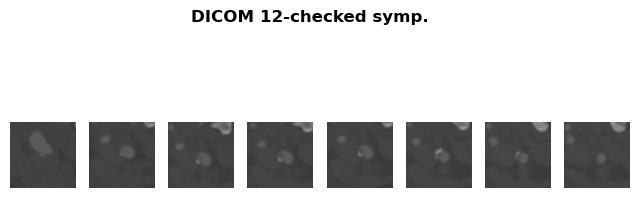

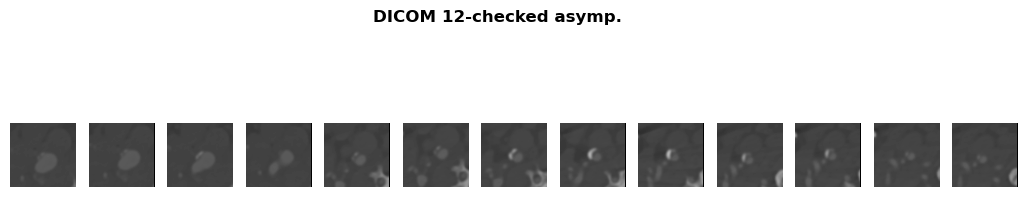

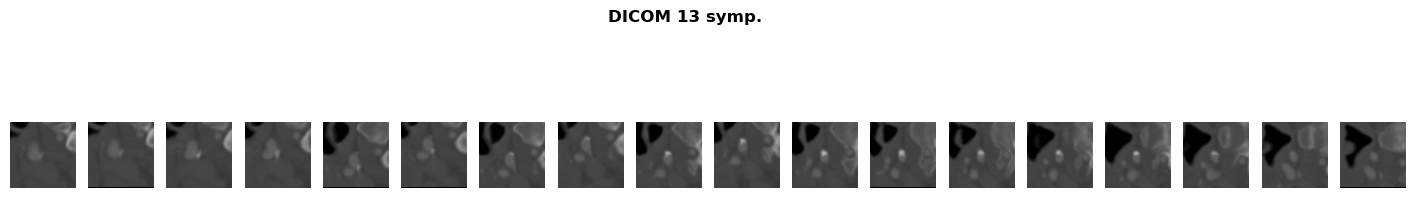

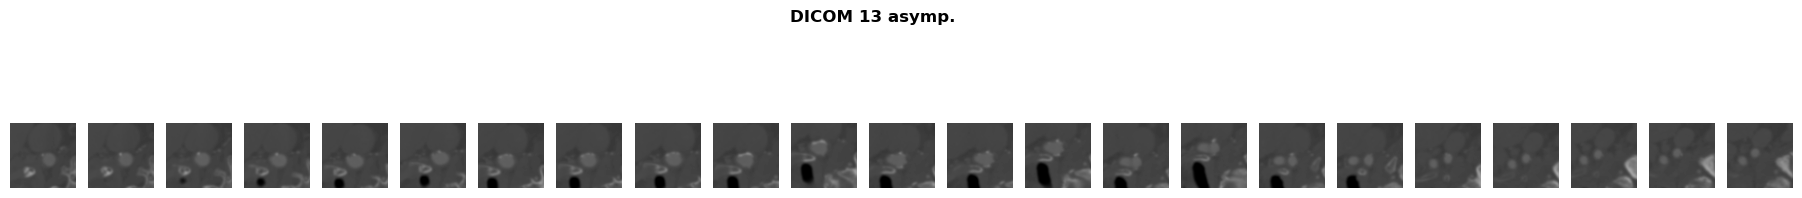

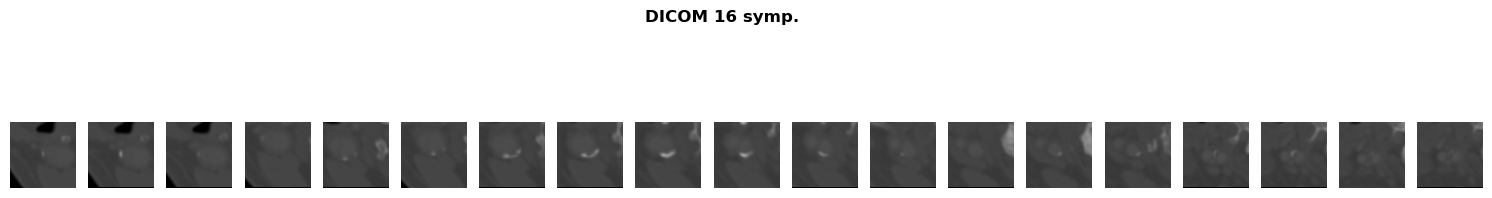

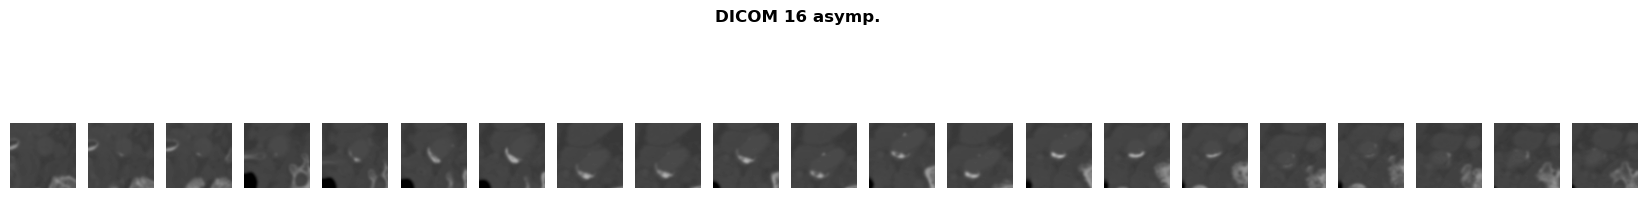

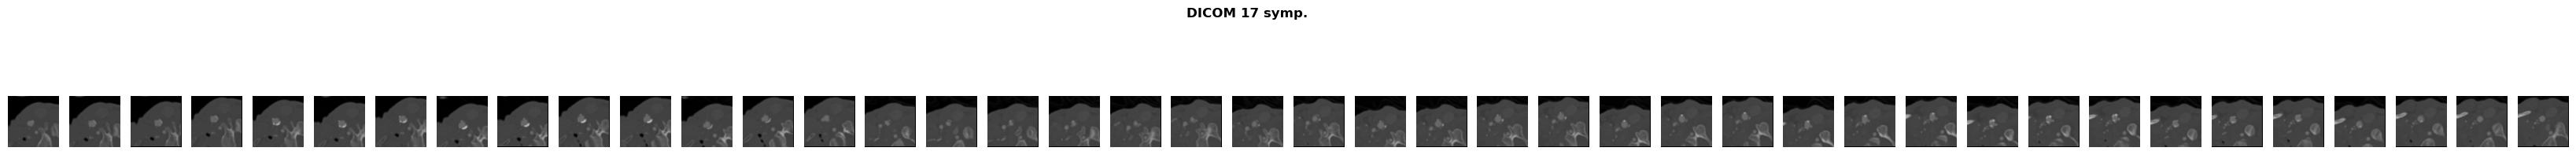

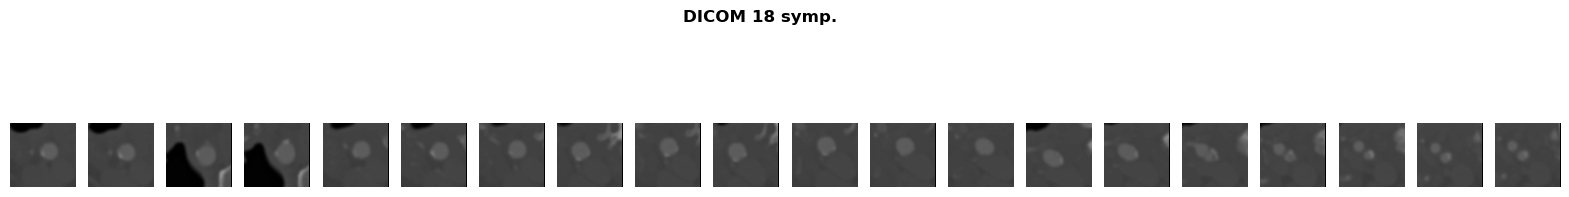

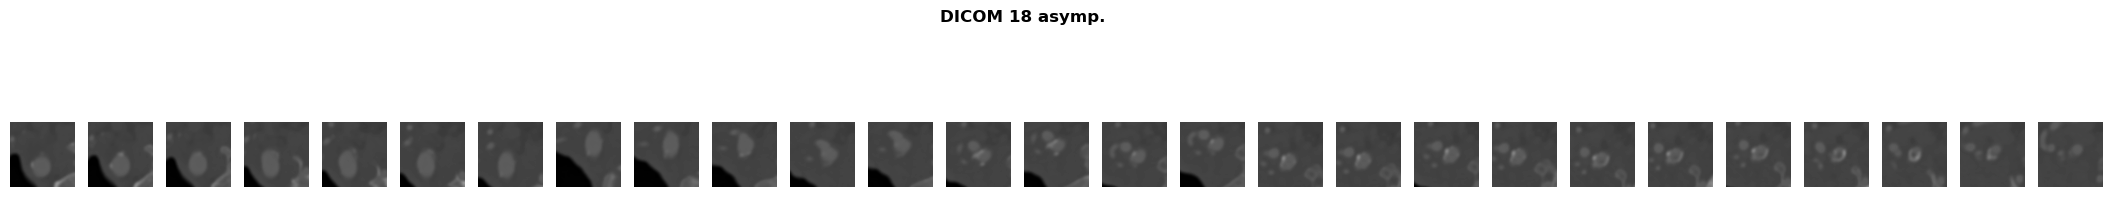

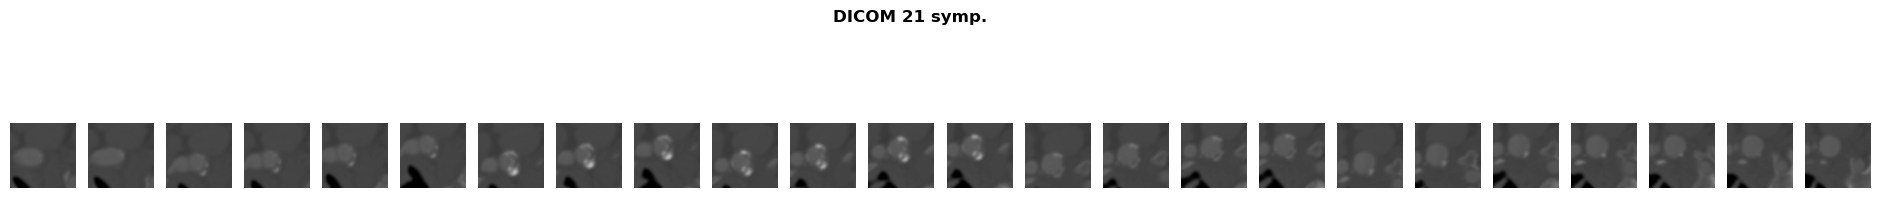

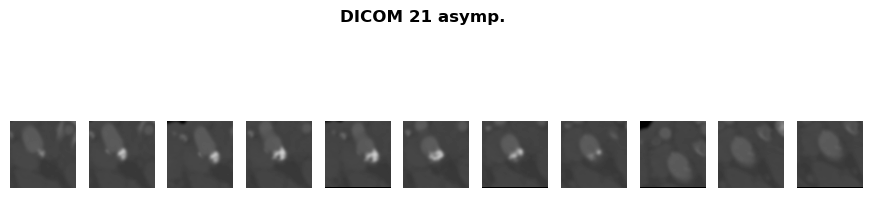

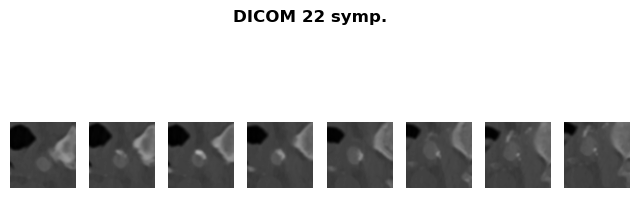

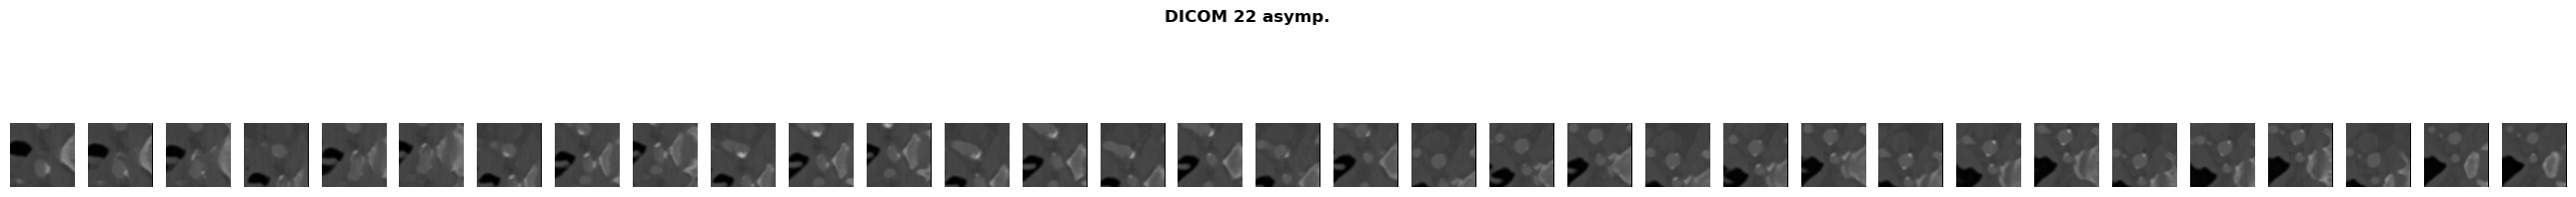

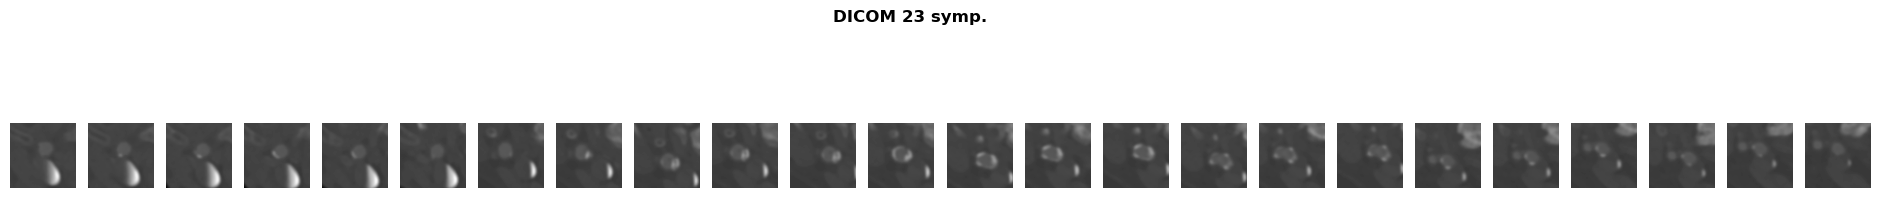

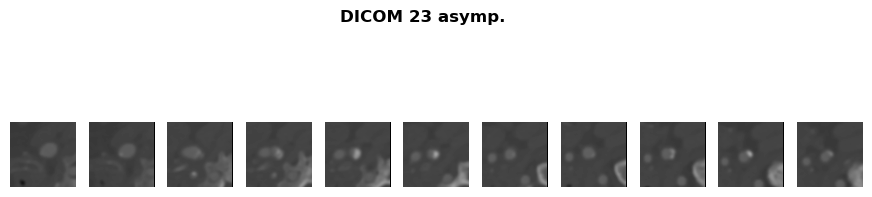

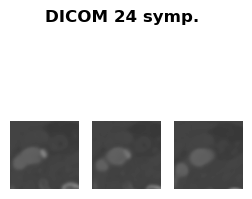

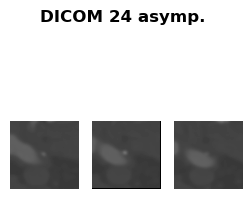

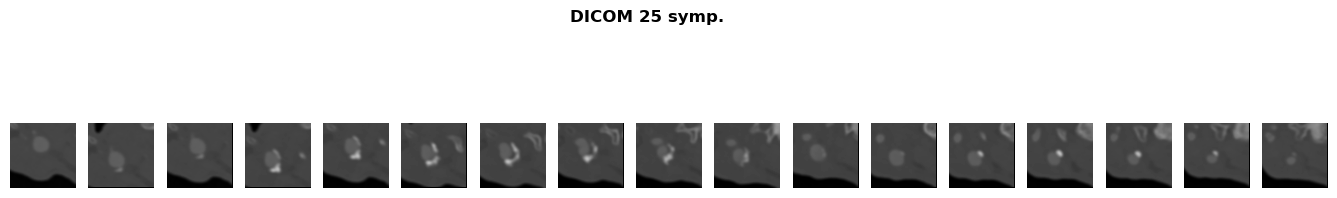

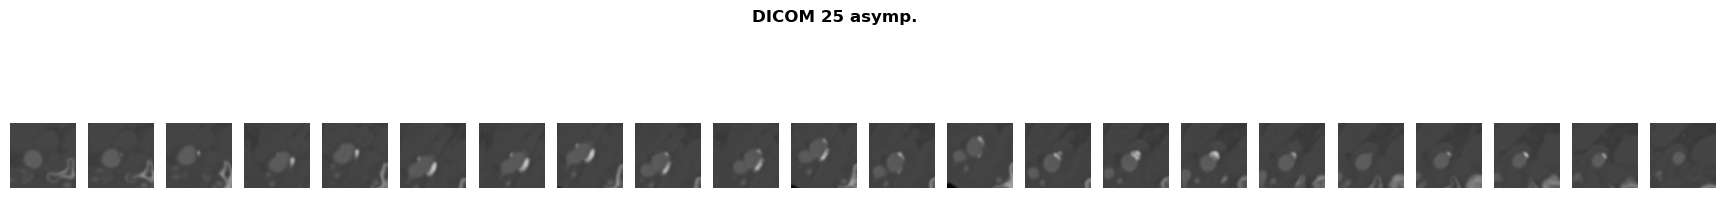

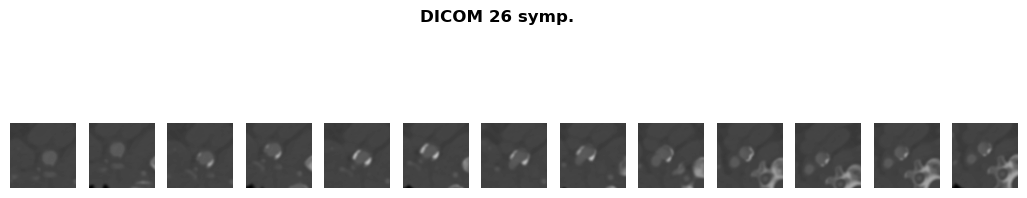

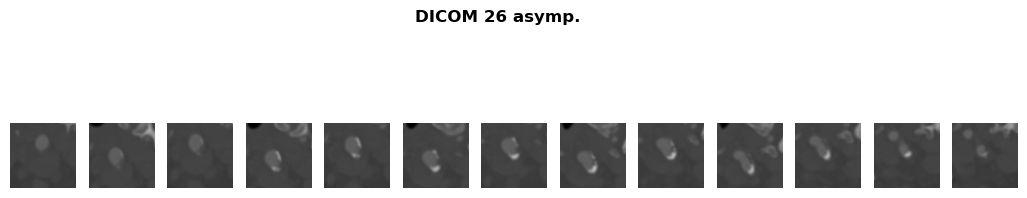

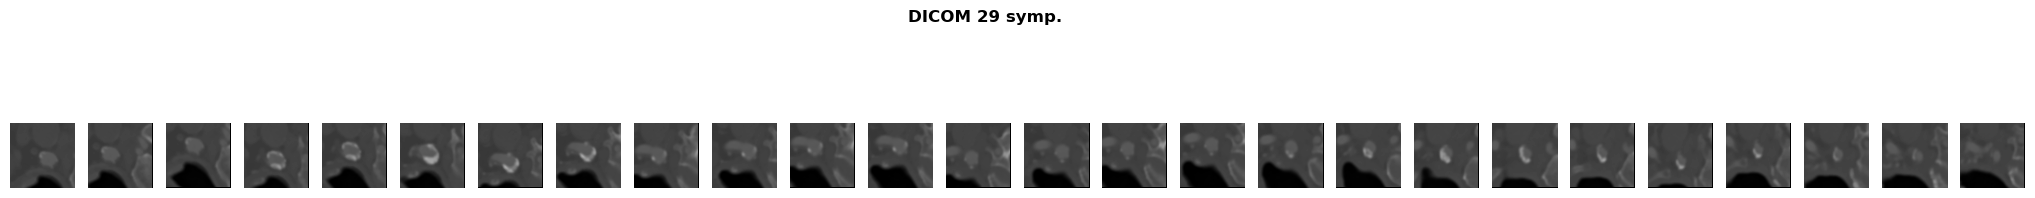

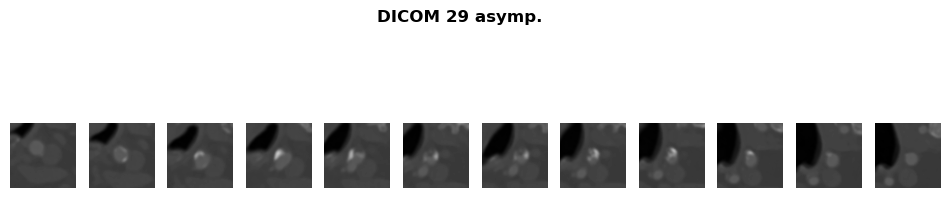

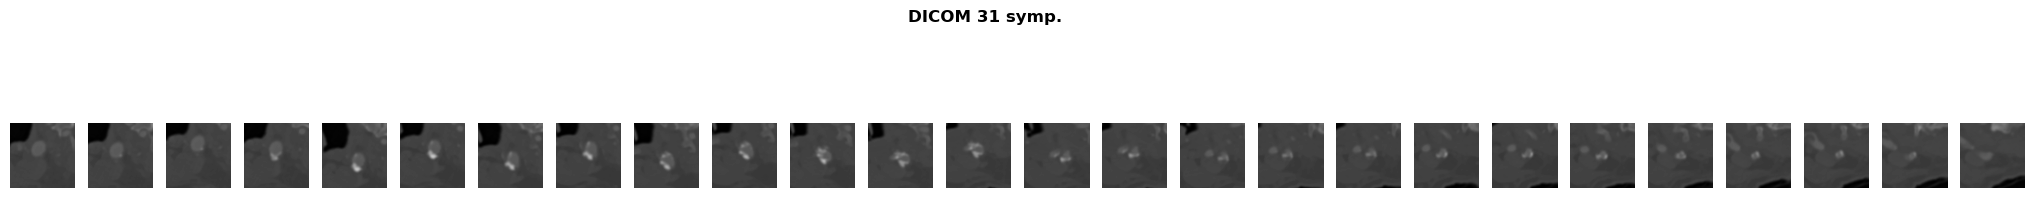

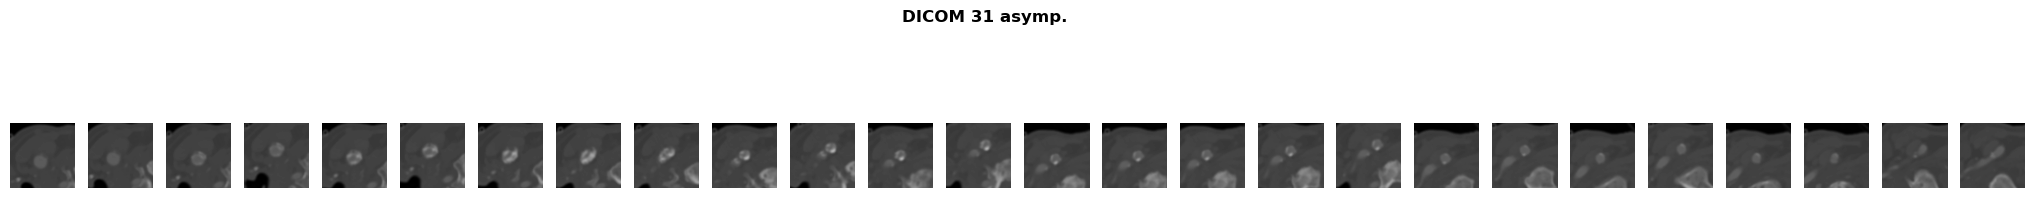

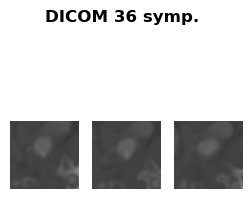

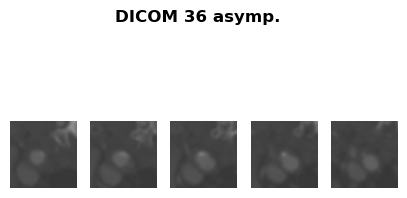

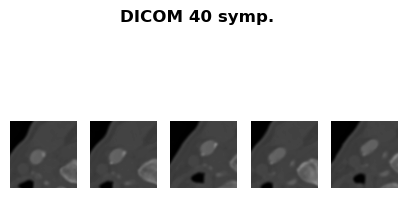

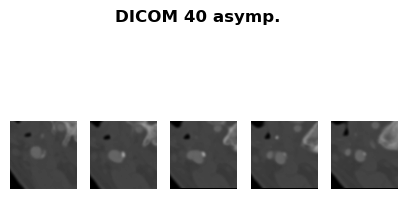

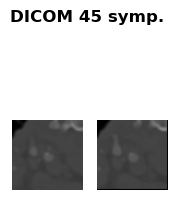

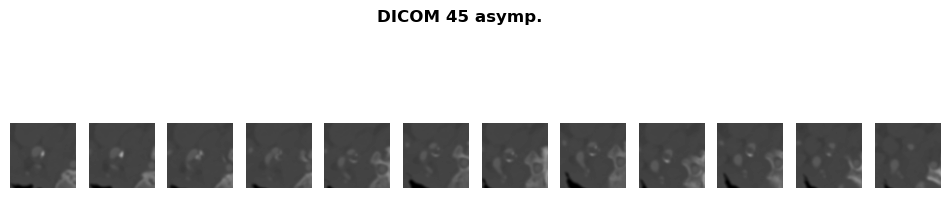

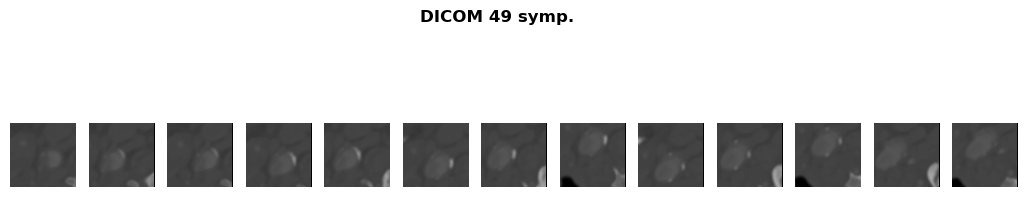

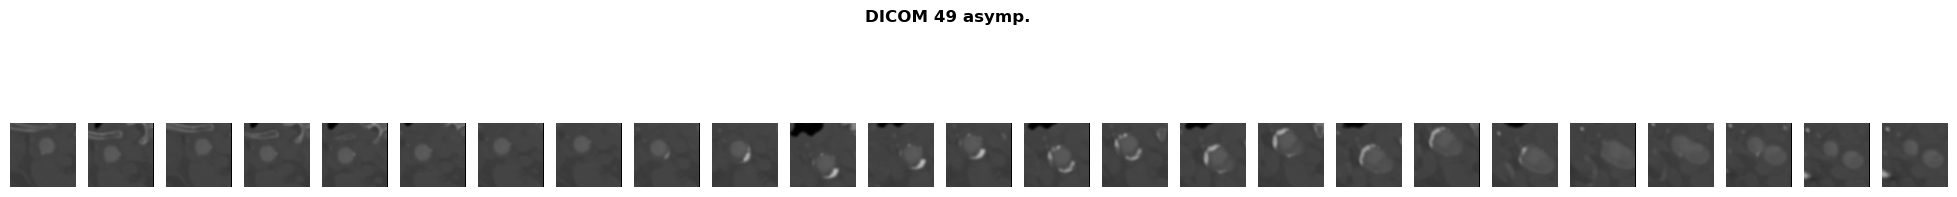

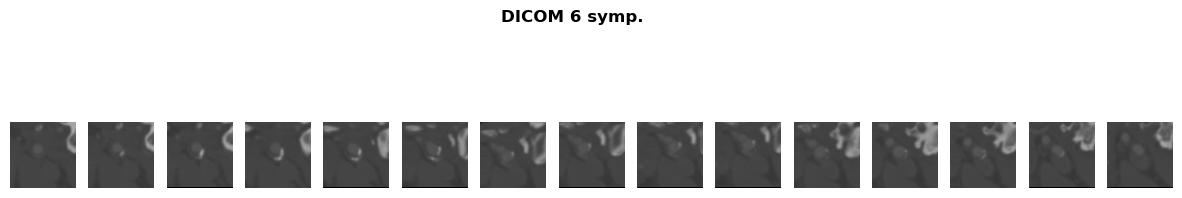

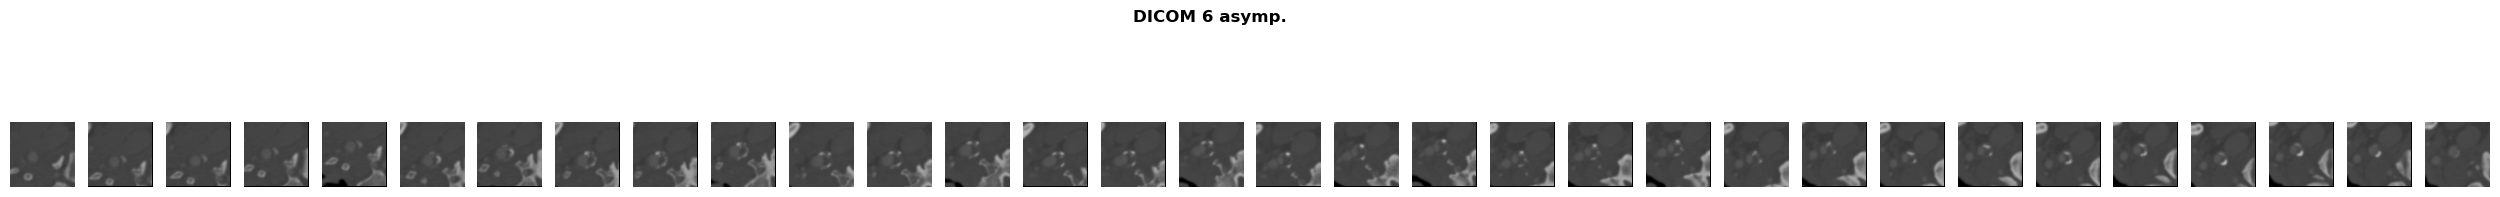

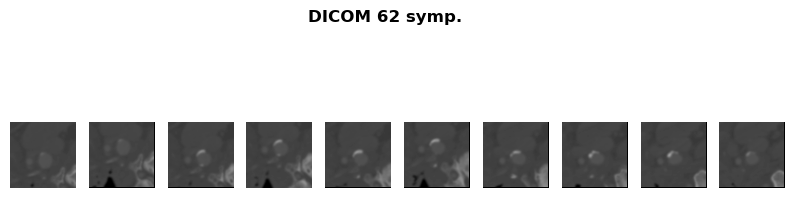

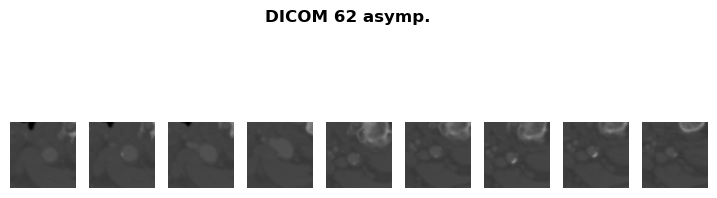

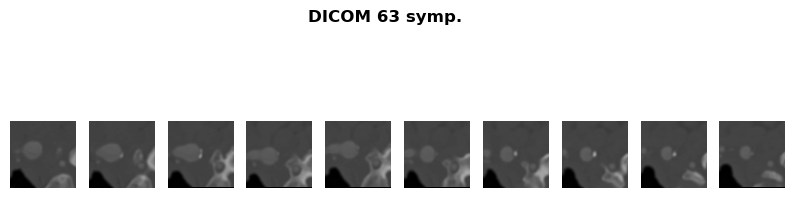

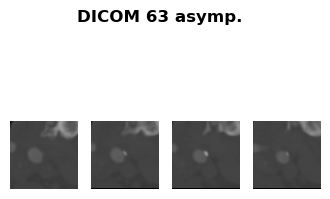

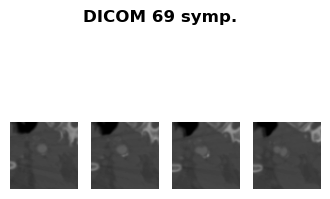

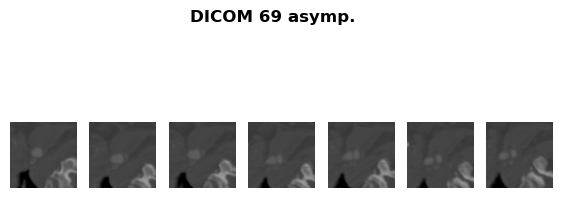

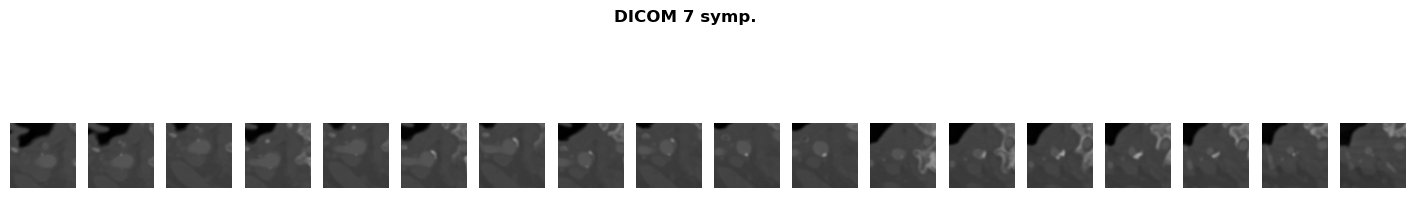

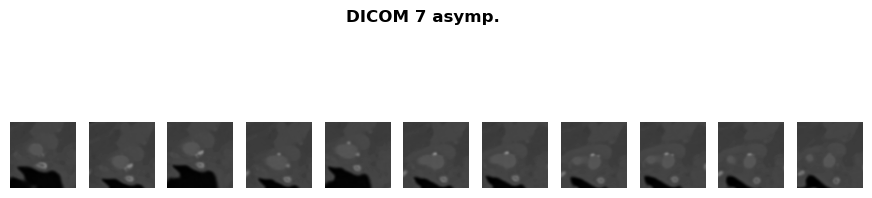

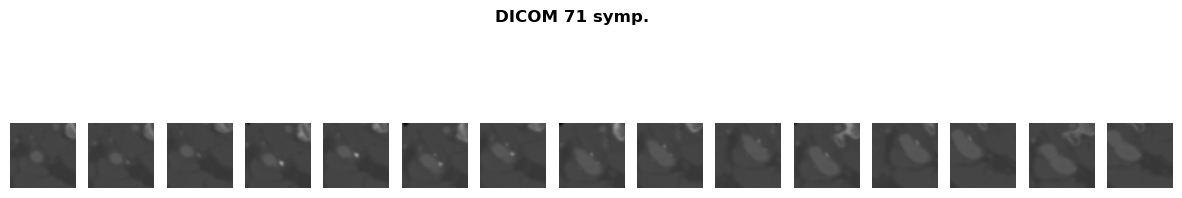

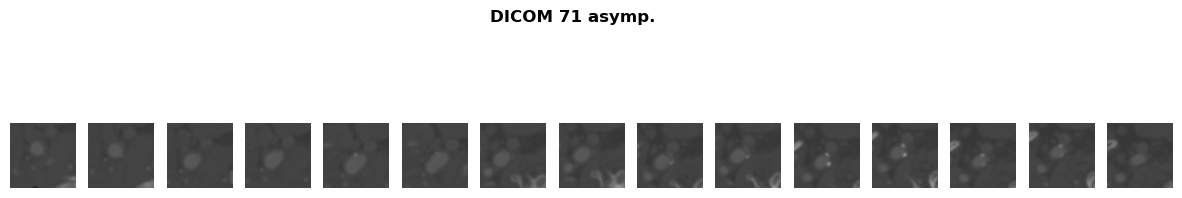

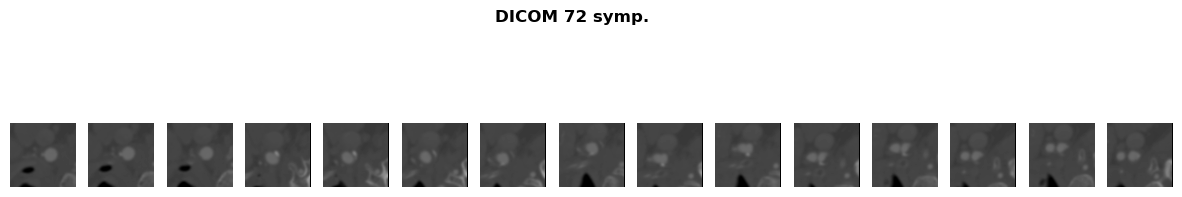

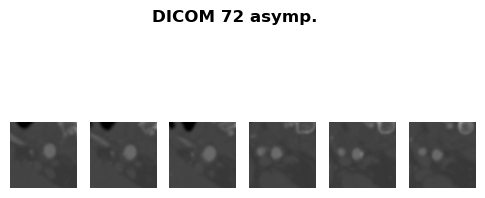

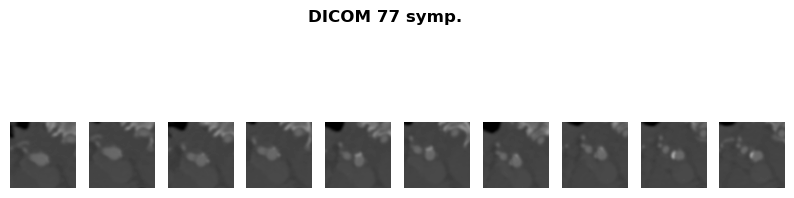

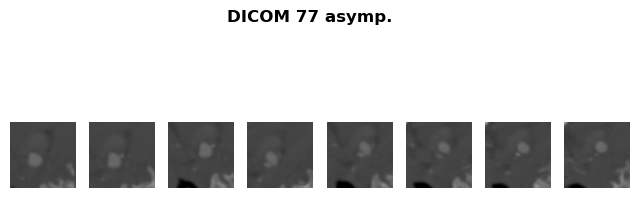

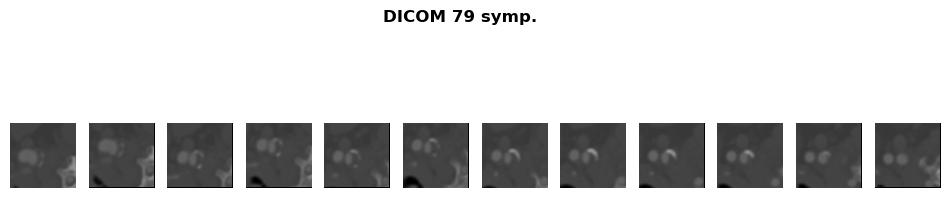

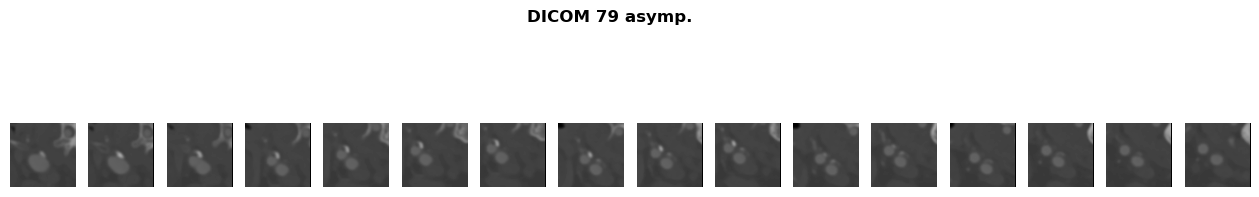

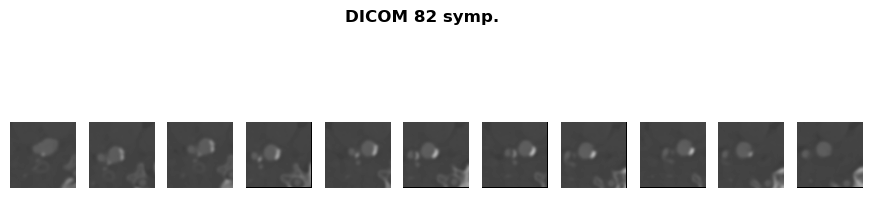

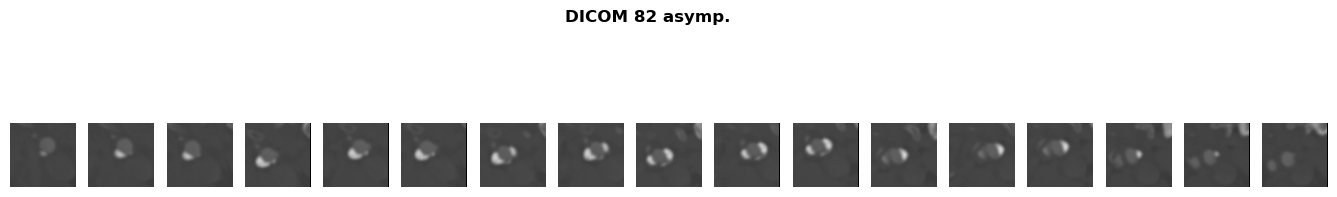

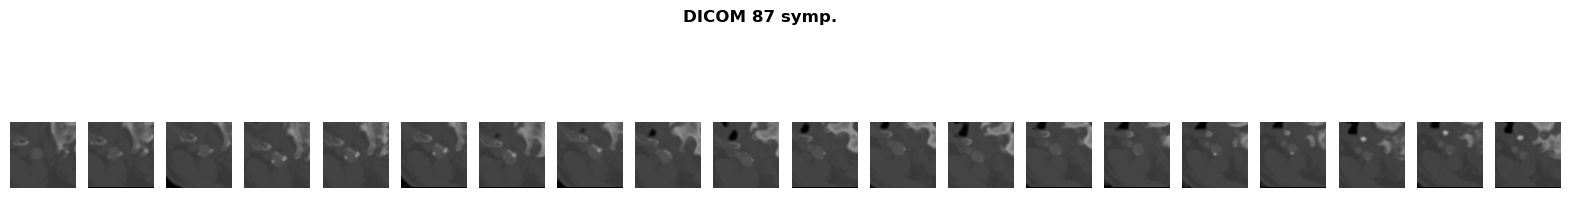

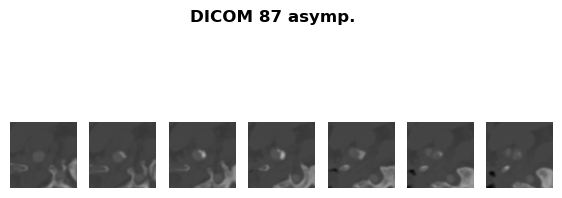

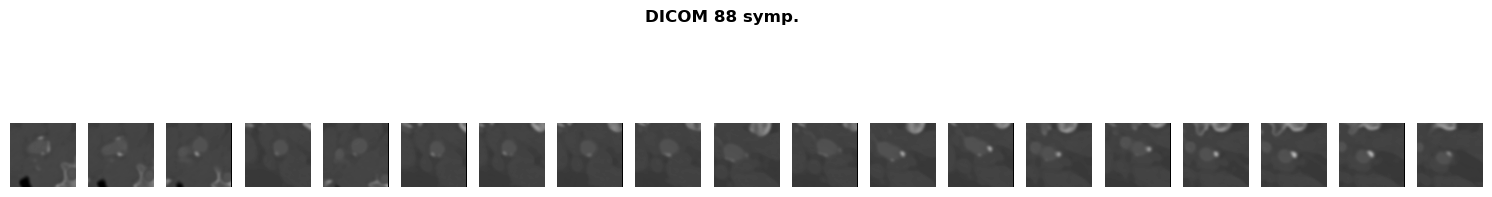

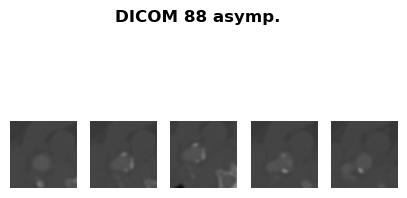

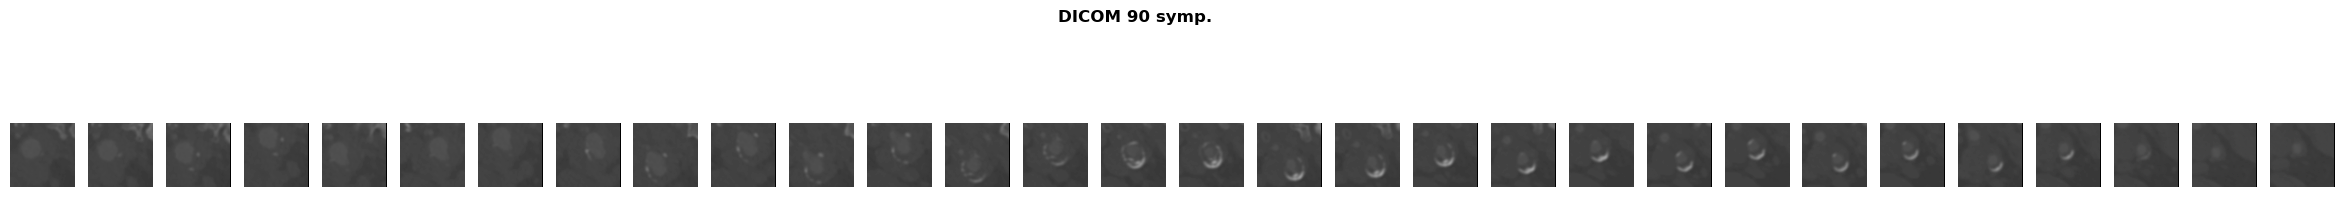

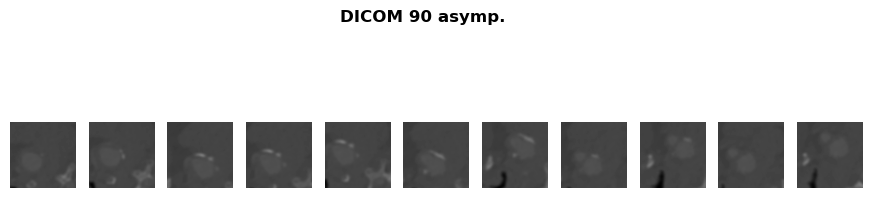

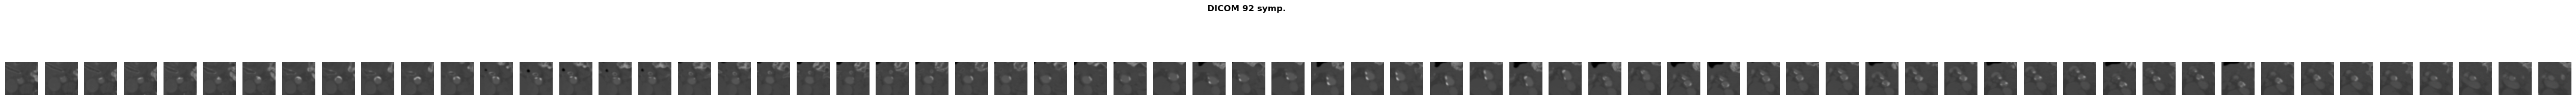

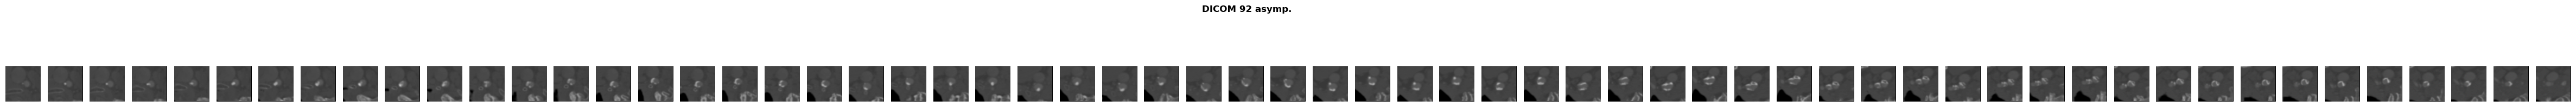

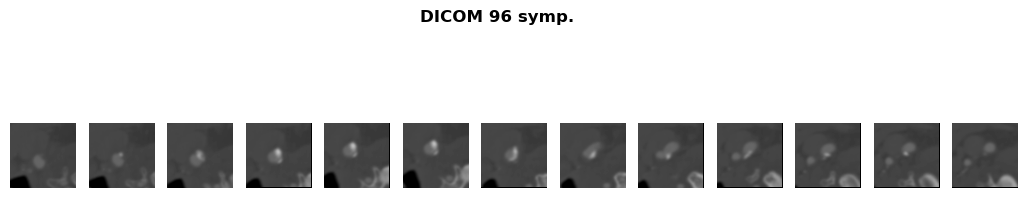

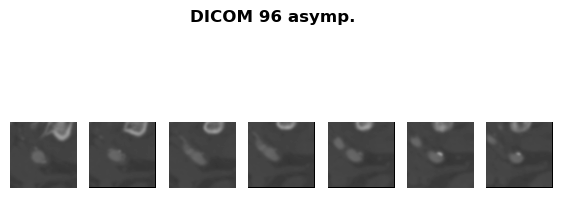

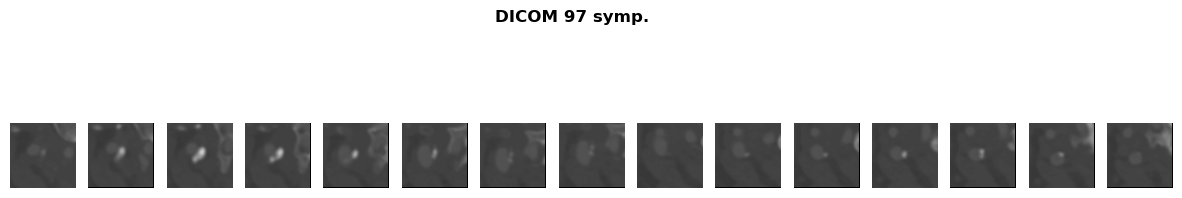

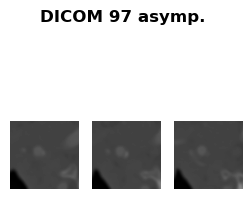

In [7]:
DATASETS = sorted([v for v in os.listdir(DATAPATH) if os.path.isdir(DATAPATH + v)])

images = []
labels = []

g_symp_i_patches = []
g_symp_l_patches = []
g_asymp_i_patches = []
g_asymp_l_patches = []

image_patches = []
label_patches = []

for i,d in enumerate(DATASETS):
    
    # ignore DICOM 12 since we have DICOM 12-checked
    if d == 'DICOM 12' or d == 'DICOM 61' or d == 'DICOM 51':
        continue
    
    print(d)

    image_with_header, label_with_header = C.Util.load(i, datapath=DATAPATH, with_header=True)

    spacing = [image_with_header[1]['space directions'][0,0],
               image_with_header[1]['space directions'][1,1],
               1]

    image = image_with_header[0]
    label = label_with_header[0]
    
    ### only support L P S
    if image_with_header[1]['space'] != 'left-posterior-superior':
        print('WARNING!! FATAL!!! ERROR!!! NO LPS!')
        break

    # left is Y axis from top 0 to bottom 512 (512 is full left, 0 is right)
    
    # get stroke side
    parsed_id = d.replace('DICOM ','').replace('-checked','')
    ### patient side
    stroke_side = STROKE_SIDES[parsed_id]
    print('Stroke side', stroke_side)
    

    # normalize grayscale to 0..1
    image_normalized = C.Util.normalize(image)
    
    # remove empty slices
    image_filtered, label_filtered = C.Util.filter(image_normalized, label)

    # for each scan
    symp_i_patches = []
    symp_l_patches = []
    asymp_i_patches = []
    asymp_l_patches = []
    
    # loop thru each slice
    for z in range(image_filtered.shape[2]):

        image_slice = image_filtered[:,:,z:z+1]
        label_slice = label_filtered[:,:,z:z+1]

        # relabel the segments
        relabel, obj = mh.label(label_slice)
        
#         print('relabeled')

        # loop thru each segment, binarize and crop
        for i in range(1, relabel.max()+1):

            single_label = np.zeros((relabel.shape), relabel.dtype)
            single_label[relabel == i] = 1

            bb = mh.bbox(single_label)

            location = ''
            if (512-bb[0] < 256):
                location = 'L' # patient view
            else:
                location = 'R' # patient view
                
            
            
            image_cropped, single_label_cropped = C.Util.crop(image_slice, single_label, target_size=P)

            if location == stroke_side:
                symp_i_patches.append(image_cropped)
                symp_l_patches.append(single_label_cropped)
            else:
                asymp_i_patches.append(image_cropped)
                asymp_l_patches.append(single_label_cropped)
                
            
#             image_patches.append(image_cropped)
#             label_patches.append(single_label_cropped)

    ### plot
    if len(symp_i_patches) > 0:
        symp_i_patches_a = C.Util.list_to_array(symp_i_patches)
        C.Util.view(symp_i_patches_a, symp_i_patches_a, vmin=0, vmax=1, alpha=0, title=d+' symp.' )
    else:
        print(d, 'no symp plaque')
    
    if len(asymp_i_patches) > 0:
        asymp_i_patches_a = C.Util.list_to_array(asymp_i_patches)
        C.Util.view(asymp_i_patches_a, asymp_i_patches_a, vmin=0, vmax=1, alpha=0, title=d+' asymp.' )
    else:
        print(d, 'no asymp plaque')
        
    g_symp_i_patches += symp_i_patches
    g_symp_l_patches += symp_l_patches
    g_asymp_i_patches += asymp_i_patches
    g_asymp_l_patches += asymp_l_patches
    

In [8]:
len(g_symp_l_patches)

553

In [9]:
g_symp_i_patches_a = C.Util.list_to_array(g_symp_i_patches)

In [10]:
g_asymp_i_patches_a = C.Util.list_to_array(g_asymp_i_patches)

In [11]:
g_symp_i_patches_a.shape

(64, 64, 553)

In [12]:
symp_count = len(g_symp_i_patches)
symp_images_npy = np.zeros((symp_count, P,P,1), dtype=symp_i_patches[0].dtype)

for i,img in enumerate(g_symp_i_patches):
    symp_images_npy[i] = g_symp_i_patches_a[0:P,0:P,i:i+1]


In [13]:
asymp_count = len(g_asymp_i_patches)
asymp_images_npy = np.zeros((asymp_count, P,P,1), dtype=asymp_i_patches[0].dtype)

for i,img in enumerate(g_asymp_i_patches):
    asymp_images_npy[i] = g_asymp_i_patches_a[0:P,0:P,i:i+1]

In [14]:
# # normalize images
# for z in range(symp_images_npy.shape[0]):
    
#     symp_images_npy[z] = (symp_images_npy[z] - symp_images_npy[z].min()) / (symp_images_npy[z].max() - symp_images_npy[z].min())

In [15]:
# # normalize images
# for z in range(asymp_images_npy.shape[0]):
    
#     asymp_images_npy[z] = (asymp_images_npy[z] - asymp_images_npy[z].min()) / (asymp_images_npy[z].max() - asymp_images_npy[z].min())

In [16]:
#
# now we can store both
#
np.save(os.path.join(DATAPATH, 'asymp_cropped_no_norm.npy'), asymp_images_npy)
np.save(os.path.join(DATAPATH, 'symp_cropped_no_norm.npy'), symp_images_npy)